<div style="background-color:royalblue">
<img src="https://d3njjcbhbojbot.cloudfront.net/web/bundles/userModal/images/coursera-logo.svg">
</div>    

# <b style="color:#3b5998">www-coursera-downloader-multi-course</b>

- this notebook release: 201600710 (fixed 20190501 by baicalin)
- notebook features: 
  - fixed bug in quiz downloader
  - html reading downloader
  - video downloader
  - creation of m3u playlist
  - added  <b style="color:#3b5998">colorful</b> heading and images
  - added section `download another course?`
  - handle courses with only `Preview Week 1`
  - added TOC
  - handle subtitle not available
  - separation of quiz downloader

(c) Jansen Simanullang, 2016-2018.

## <div align='center'><a href='#toc'><b style='color:#3b5998'>TABLE OF CONTENTS</b></a></div>
### <a href='#all'><b style="color:#3b5998">A. All Required Software</b></a>
### <a href='#before'><b style="color:#3b5998">B. Before Login</b></a>
### <a href='#coursera'><b style="color:#3b5998">C. Coursera</b></a>
### <a href='#download'><b style="color:#3b5998">D. Download Another Course?</b></a>
### <a href='#error'><b style="color:#3b5998">E. Error Checking</b></a>
### <a href='#finally'><b style="color:#3b5998">F. Finally Close the Browser</b></a>
### <a href='#goodbye'><b style="color:#3b5998">G. Go Back to Login</a></b>

## <a name = 'all'><b style='color:#3b5998'>A. All Required Softwares</b></a>

Run once to install all required software.

### <b style='color:#3b5998'>(1) Install Mozilla Geckodriver</b>
<img src="https://avatars2.githubusercontent.com/u/131524?s=200&v=4" width="75" height="75" alt="@mozilla" align="center"><br>
<li>Install [Mozilla Geckodriver](https://github.com/mozilla/geckodriver/releases/)
</li>

#### <b style="color:royalblue">Check Geckodriver version</b>

In [1]:
!echo Checking geckodriver version...
!geckodriver --version

Checking geckodriver version...
geckodriver 0.24.0 ( 2019-01-28)

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### <b style="color:#3b5998">(2) Install Some Python Packages</b>
<img src="https://pypi.org/static/images/logo-small.6eef541e.svg">

In [2]:
!pip install -q jupyter_contrib_nbextensions jupyter_nbextensions_configurator

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!pip install -q bs4 mutagen pillow requests splinter

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
# You can skip below codes; just run cells, not markdown
# !jupyter contrib nbextension install

In [5]:
# !jupyter nbextensions_configurator enable

In [6]:
# !jupyter nbextension enable python-markdown/main

## <a name='before'><b style="color:#3b5998">B. Before Login</b></a>

### <b style="color:#3b5998">B. 1 Python Package Imports</b>

In [7]:
from splinter import Browser
import base64, getpass, json, os, re, requests, sys, time
from bs4 import BeautifulSoup
from mutagen.mp4 import MP4

### <b style="color:royalblue">B. 2 Some Constants</b>

In [8]:
# LOADING TIME
# WARNING: this will impact your user experience!
# adjust loading time according to your network speed!
# loading time in seconds

loading_time = 5

# HOMEPAGE
homepage='https://www.coursera.org'

# VIDEO RESOLUTION
# available resolution:
# 'hi', 'low' or 'med'
# choose according to your preference
resolution = {'low':'360','med':'540','hi':'720'}
chosen_res = 'hi'

# INITIAL DIRECTORY
initial_dirname = os.getcwd()

###  <b style="color:royalblue">B.3 Helper Functions</b>

<img src="https://www.3di.co.uk/wp-content/uploads/2016/06/Define.png" height="150" width="250">

In [9]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

# SCREENSHOT
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

# button click
def button_click(text_):
    try:
        buttons = browser.find_by_css('button')
        for button in buttons:
            if button.text == text_:
                print(text_)
                button.click()
                break
    except:
        pass

# cjson helper functions

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():

    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():

    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

# vtt file conversion

def read_text_file(file_name):
    f = open(file_name, "r")
    print("\nvtt file being converted to srt: " + file_name)  
    return f.read()

def file_create(file_name, str_data):
    try:  
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    except IOError:        
        file_name = file_name.split(os.sep)[-1]
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    print("file created: " + file_name)
    
def convert_content(file_contents):
    replacement = re.sub(r'([\d]+)\.([\d]+)', r'\1,\2', file_contents)
    replacement = re.sub(r'WEBVTT\n\n', '', replacement)
    replacement = re.sub(r'^\d+\n', '', replacement)
    replacement = re.sub(r'\n\d+\n', '\n', replacement)
    return replacement

def vtt_to_srt(file_name):
    
    file_contents = read_text_file(file_name)
    str_data = ""
    str_data = str_data + convert_content(file_contents)  
    file_name = file_name.replace(".vtt",".srt")
    print(file_name)
    file_create(file_name, str_data)
    
# 
    
def get_mp4_url(lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        print('video playing will be paused in ' + str(loading_time) + ' seconds...')
        time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
#     mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = browser.find_by_tag('video')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

def get_vtt_url(lesson_url):
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    element = browser.find_by_css('li.rc-SubtitleDownloadItem.resource-list-item')
    vtt = BeautifulSoup(element.html, 'lxml').findAll('a')[0]['href']
    vtt = homepage + vtt
    return vtt

In [10]:
def vtt_downloader(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)    
    file_name = base_filename + '.vtt'
    file_exists = os.path.isfile(file_name)

    if file_exists:
        print('subtitle already downloaded.')
    else:
        try:
            vtt = get_vtt_url(lesson_url)
            r = requests.get(vtt)
            f = open(file_name, 'w')
            f.write(r.text)
            f.close()
            vtt_to_srt(file_name)
        except:
            print('subtitle not yet available')
            pass
        
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('mp4 already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.0f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')

In [11]:
def reformat_html(html, page_title):
    
    # reading
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>',
                        '')
    
    return html    
    
def reformat_html_quiz(html, page_title):    
    # quiz
    html = html.replace('<div class="header-back-arrow"><button class="back nostyle" role="button" tabindex="0"><i class="cif-back headline-2-text"></i><span class="screenreader-only">Back</span></button></div>',
                        '')
    html = html.replace('<div data-rc="ItemFeedback" class="c-quiz-item-feedback"><div data-reactroot="" class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div>',
                        '')
    
    return html

def write_html(base_filename, html):
    
    html = reformat_html(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def write_html_quiz(base_filename, html):
    
    html = reformat_html_quiz(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
    
def quiz_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    button_click('Continue')
    button_click('Start')
    button_click('Resume')
    button_click('Start Quiz')
    
    try:
        time.sleep(loading_time)
        html = browser.find_by_css('div.rc-FullscreenLayoutHandler').html
        print('got quiz item')
        base_filename = lesson_id +'-'+ safe_text(lesson_title)
        write_html_quiz(base_filename, html)
    except:
        print('something wrong...')
        html ='no quiz content scraped.'
        pass
    

def html_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    try:
        write_html(base_filename, html)
    except:
        # file name too long
        write_html(base_filename[:55], html)
    
    return

def check_html_reading(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('html already downloaded.')
    else:
        html_downloader(lesson_id, lesson_title, lesson_url)
        

def check_mp4(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title).replace('?','Q')
    file_name = base_filename + '.mp4'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('mp4 already downloaded.')
    else:
        mp4_downloader(lesson_id, lesson_title, lesson_url)
        
        
def check_vtt(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.vtt'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('vtt already downloaded.')
    else:
        vtt_downloader(lesson_id, lesson_title, lesson_url)
        

def check_quiz(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('quiz already downloaded.')
    else:
        quiz_downloader(lesson_id, lesson_title, lesson_url)
        
### CREATE m3u PLAYLIST FILE
def create_m3u_playlist(course_title):
    os.chdir(safe_text(course_title))
    seq = 0
    m3u_text = '#EXTM3U'+'\n'
    for root, dirs, files in os.walk(os.getcwd(), topdown=False):
        for name in sorted(files):
            if 'mp4' in name:
                seq += 1
                #mp4 = os.path.join(root, name)
                mp4 = (name)
                m3u_text += ('#EXTINF:'+str(int((MP4(mp4).info.length)))+','+ name) + '\n'
                m3u_text += (mp4) + '\n'
    playlist_base_name = safe_text(course_title).replace(' ','-')
    playlist_name = '000-'+playlist_base_name + '.m3u'
    f = open(playlist_name, 'w')
    f.write(m3u_text)
    f.close()
    print('playlist file created: '+playlist_name)
    os.chdir(initial_dirname)

In [12]:
def enumerate_weeks(lecture_homepage):
    
    browser.visit(lecture_homepage)
    time.sleep(loading_time)
    weeks = []
    
    if browser.find_by_text('Preview Week 1'):
        
        week = lecture_homepage.replace('welcome','week/')
        week = week[week.index('/learn'):]

        for i in range(4):
            if 'week' not in week:
                week += '/week/'
            weeks.append(week+ str(i+1))
    
    else:
    
        week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
        anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
        for a in anchors:
            weeks.append(a['href']) 
            
    sys.stdout.flush()

    return weeks

In [13]:
def enumerate_lessons(lecture_homepage):
    
    weeks = enumerate_weeks(lecture_homepage)
    w_digit = len(str(len(weeks)))

    lessons_i = []
    lessons_t = []
    lessons_u = []
    
    for w in range(len(weeks)):
    
        browser.visit(homepage + weeks[w])
        time.sleep(loading_time)
        w = w+1
    
        sys.stdout.write('\r'+'{:116.49}'.format('Collecting titles and urls from week: ' + str(w)))
        time.sleep(loading_time)
        module_lessons = browser.find_by_css('div.rc-ModuleLessons')
        sys.stdout.flush()
        sys.stdout.write('\rWeek '+str(w)+' titles:')
        seq = 0
        for i, module_lesson in enumerate(module_lessons):

            lessons_title = module_lesson.find_by_tag('.headline-1-text')

            for j, l in enumerate(lessons_title):
                seq  += 1
                lesson_id = str(w*100+seq).zfill(w_digit+2)
                print(lesson_id)
                title = l.text.replace('\n',' ')
                sys.stdout.write('\r'+lesson_id+', '+title)
                title = safe_text(title)
                lessons_t.append(title)
                lessons_i.append(lesson_id)
    
        sys.stdout.flush()
        sys.stdout.write('\rWeek '+str(w)+' links:')    
        seq = 0

        for i, module_lesson in enumerate(module_lessons):

            lessons_url = module_lesson.find_by_tag('ul')
    
            for j, e in enumerate(lessons_url):
                anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
                for k, a in enumerate(anchors):
                    seq += 1
                    lesson_id = str(w*100+seq).zfill(w_digit+2)
                    lesson_url = a['href']
                    sys.stdout.write('\r'+lesson_id+', '+ lesson_url)
                    lessons_u.append(lesson_url)
           
        sys.stdout.flush()
    msg = 'There are '+str(len(lessons_u)) + ' lesson titles available to check.'
    sys.stdout.write('\r'+'{:200.200}'.format(msg))
    sys.stdout.flush()     
    sys.stdout.write('\n')
    return lessons_i, lessons_t, lessons_u

In [14]:
def download_videos(lessons):
    
    os.chdir(initial_dirname)
    os.chdir(safe_text(course_title))
    
    for a,b,c in lessons:
        print(a,b)
        first_word = b.split(' ')[0]
    
        if 'Lecture' in first_word:
            check_mp4(a,b.replace('?','Q'),c)
            vtt_downloader(a,b.replace('?','Q'),c)
            print()
            
        else:
            sys.stdout.write('\rno video resource to download.\n')
        
        sys.stdout.flush()
    sys.stdout.write('\rVideos downloaded to:'+os.getcwd() + '\n')
    os.chdir(initial_dirname)
    
def download_html(lessons):
    
    os.chdir(initial_dirname)
    os.chdir(safe_text(course_title))
    h_ = 0
    for a,b,c in lessons:
        print(a,b)
        first_word = b.split(' ')[0]
           
        if 'Reading' in first_word:
            check_html_reading(a, b, c)
            h_ += 1
            print()
    
        else:
            sys.stdout.write('\rno html resource to download.\n')
        
        print()
    if h_:
        sys.stdout.write('\rHTML Resources downloaded to: '+os.getcwd() + '\n')
    else:
            sys.stdout.write('\rno html resource downloaded.\n')
    os.chdir(initial_dirname)
    
def download_quiz(lessons):
    
    os.chdir(initial_dirname)
    os.chdir(safe_text(course_title))
    q_ = 0
    for a,b,c in lessons:
        print(a,b)
        first_word = b.split(' ')[0]
    
        if ('Quiz' in first_word) or ('Practice Quiz' in b):
            check_quiz(a, b, c)
            q_ += 1
            sys.stdout.flush()
        else:
            sys.stdout.write('\rno quiz to download.\n')
        
        sys.stdout.flush()
    if q_: 
        sys.stdout.write('\rQuizzes downloaded to: '+os.getcwd()+'\n')
    else:
            sys.stdout.write('\rno quiz resource downloaded.\n')    
    os.chdir(initial_dirname)
    
def download_all(lessons):
    for a,b,c in lessons:
        sys.stdout.write(a+','+b+'\n')
        first_word = b.split(' ')[0]
        print(first_word)
        if 'Video' in first_word:
            check_mp4(a,b.replace('?','Q'),c)
            vtt_downloader(a,b.replace('?','Q'),c)
            print()
        
        elif 'Reading' in first_word:
            check_html_reading(a, b.replace('?','Q'), c)
            print()
        
        elif ('Quiz' in first_word) or ('Practice Quiz' in b):
            check_quiz(a, b.replace('?','Q'), c)
            print()
    
        else:
            try:
                check_html_reading(a, b.replace('?','Q'), c)
            except:
                sys.stdout.write('\rno resource to download.\n')
            
    os.chdir(initial_dirname)


##  <a name='coursera'><b style="color:#3b5998">C. Coursera</b></a>

###  <a name='login'><b style="color:royalblue">(1) Login Page</b></a>


In [22]:
browser = Browser('firefox', headless = False)

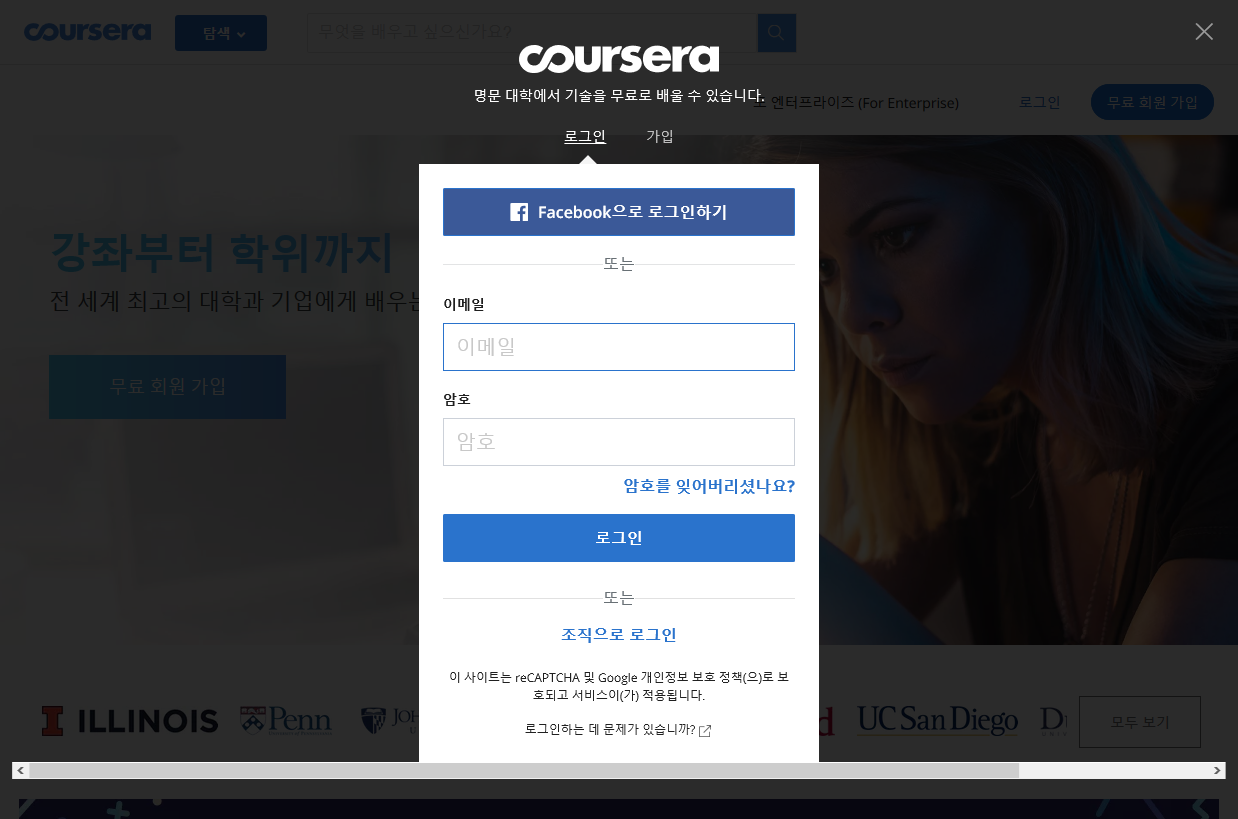

In [23]:
# do not resize window size
# login yourself, break through capcha
browser.driver.set_window_size(1250, 900)
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

###  <b style="color:royalblue">Insert Login Credential</b>

###  <a name="last-active-courses"><b style="color:royalblue">LAST ACTIVE COURSES</b></a>

###  <b style="color:royalblue">PICK ONE OR MORE OF THE COURSES</b>
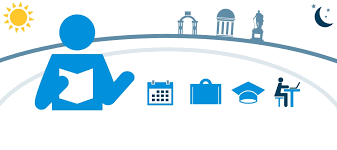



In [24]:
browser.visit(homepage)

courses_i = []
courses_t = []
courses_u = []

anchors =  browser.find_by_css('div.course-info.flex-1')
for i, anchor in enumerate(anchors):
    soup = BeautifulSoup(anchor.html, 'lxml').find('a')
    courses_i.append(str(i+1))
    courses_t.append(anchor.find_by_css('h4').text)
    courses_u.append(soup['href'])
    print(str(i+1), anchor.find_by_css('h4').text)

try:
    chosen_course = input('Choose one or several course number from [1] to ['+ str(len(courses_i))+'] separated by comma:\n')
except:
    chosen_course = 1

1 Machine Learning
Choose one or several course number from [1] to [1] separated by comma:
1


In [25]:
courses = zip(courses_i, courses_t, courses_u)
chosen_courses =[]

for e in chosen_course.split(','):
    chosen_courses.append(e.strip())
chosen_courses
print('>> You choose:')
for e in chosen_courses:
    course_title = courses_t[int(e)-1]
    print(e + ' '+course_title)

>> You choose:
1 Machine Learning


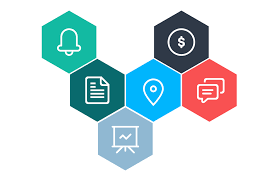

### Download Lecture Videos and Readings
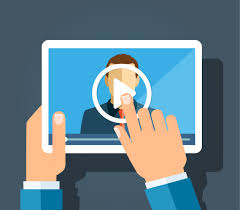

See the progress of downloading lecture videos, readings and quizzes.

In [26]:
for e in chosen_courses:
    
    course_title = courses_t[int(e)-1]
    print(e + ' '+course_title)
    lecture_homepage = homepage + courses_u[int(e)-1]
    os.chdir(initial_dirname)
    create_download_dir(courses_t[ int(e)- 1])
        
    a,b,c = enumerate_lessons(lecture_homepage)
    lessons = zip(a,b,c)
    
    download_all(lessons)
    create_m3u_playlist(course_title)
    #download_quiz(lessons = zip(a,b,c))
    #download_html(lessons = zip(a,b,c))
    
    os.chdir(initial_dirname)
    print('all requested download finished')
    print()

1 Machine Learning
C:\Users\scute\Downloads\www-coursera-downloader-master\www-coursera-downloader-master\Untitled Folder\Machine Learning
Week 1 titles:0101and urls from week: 1                                                                             
0101, 비디오: 강의 Welcome to Machine Learning!0102
0102, 읽기 자료: 읽기 자료 Machine Learning Honor Code0103
0103, 비디오: 강의 Welcome0104
0104, 비디오: 강의 What is Machine Learning?0105
0105, 읽기 자료: 읽기 자료 What is Machine Learning?0106
0106, 읽기 자료: 읽기 자료 How to Use Discussion Forums0107
0107, 비디오: 강의 Supervised Learning0108
0108, 읽기 자료: 읽기 자료 Supervised Learning0109
0109, 비디오: 강의 Unsupervised Learning0110
0110, 읽기 자료: 읽기 자료 Unsupervised Learning0111
0111, 읽기 자료: 읽기 자료 Who are Mentors?0112
0112, 읽기 자료: 읽기 자료 Get to Know Your Classmates0113
0113, 읽기 자료: 읽기 자료 Frequently Asked Questions0114
0114, 읽기 자료: 읽기 자료 Lecture Slides0115
0115, 테스트: Introduction0116
0116, 비디오: 강의 Model Representation0117
0117, 읽기 자료: 읽기 자료 Model Representation0118
0118, 비디오: 강의 Cost 

Week 7 titles:0701and urls from week: 7                                                                             
0701, 비디오: 강의 Optimization Objective0702
0702, 비디오: 강의 Large Margin Intuition0703
0703, 비디오: 강의 Mathematics Behind Large Margin Classification0704
0704, 비디오: 강의 Kernels I0705
0705, 비디오: 강의 Kernels II0706
0706, 비디오: 강의 Using An SVM0707
0707, 읽기 자료: 읽기 자료 Lecture Slides0708
0708, 테스트: Support Vector Machines0709
Week 8 titles:0801and urls from week: 8                                                                             
0801, 비디오: 강의 Unsupervised Learning: Introduction0802
0802, 비디오: 강의 K-Means Algorithm0803
0803, 비디오: 강의 Optimization Objective0804
0804, 비디오: 강의 Random Initialization0805
0805, 비디오: 강의 Choosing the Number of Clusters0806
0806, 읽기 자료: 읽기 자료 Lecture Slides0807
0807, 테스트: Unsupervised Learning0808
0808, 비디오: 강의 Motivation I: Data Compression0809
0809, 비디오: 강의 Motivation II: Visualization0810
0810, 비디오: 강의 Principal Component Analysis Problem Formulation

no resource to download.
0518,Programming Assignment Neural Network Learning
Programming
no resource to download.
0601,비디오 강의 Deciding What to Try Next
비디오
no resource to download.
0602,비디오 강의 Evaluating a Hypothesis
비디오
no resource to download.
0603,읽기 자료 읽기 자료 Evaluating a Hypothesis
읽기
no resource to download.
0604,비디오 강의 Model Selection and Train Validation Test Sets
비디오
no resource to download.
0605,읽기 자료 읽기 자료 Model Selection and Train Validation Test Sets
읽기
no resource to download.
0606,비디오 강의 Diagnosing Bias vs. Variance
비디오
no resource to download.
0607,읽기 자료 읽기 자료 Diagnosing Bias vs. Variance
읽기
no resource to download.
0608,비디오 강의 Regularization and Bias Variance
비디오
no resource to download.
0609,읽기 자료 읽기 자료 Regularization and Bias Variance
읽기
no resource to download.
0610,비디오 강의 Learning Curves
비디오
no resource to download.
0611,읽기 자료 읽기 자료 Learning Curves
읽기
no resource to download.
0612,비디오 강의 Deciding What to Do Next Revisited
비디오
no resource to download.
0613,읽기 자료 읽기 자

## <a name='#download'><b style="color:#3b5998">D. Download Another Course?</b></a>

<a href="#last-active-courses">YES, Click Here</a> 

- then RUN the cells on LAST ACTIVE COURSES and continue to choose another course. 
- You may want to use your browser and open the corresponding course if the course is not seen the last active course list.

<a href="#close">NO, quit</a> 

- then RUN the cells with `browser.quit()` command.

##  <a name='error'><b style="color:#3b5998">E. Error Checking</b></a>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXcI6o52Fkp4wQV6fET12lDBZl1ZfqQpwdGP9265fpkVu3hc6k8Q">

### <b style="color:#3b5998">(1) Current URL Checking</b>

In case of an error, you may want to check the current URL and reload the current URL.

In [43]:
browser.driver.current_url

'https://www.coursera.org/learn/art-science-ml/home/week/3'

#### Reload Current URL

In [44]:
browser.visit(browser.driver.current_url)

###  <b style="color:#3b5998">(2) Current Screenshot Checking</b>

In case of an error, you may also want to check the screenshot.

If the screenshot is blank, then the page was not yet loaded into the browser. Please try again or check your network connection.

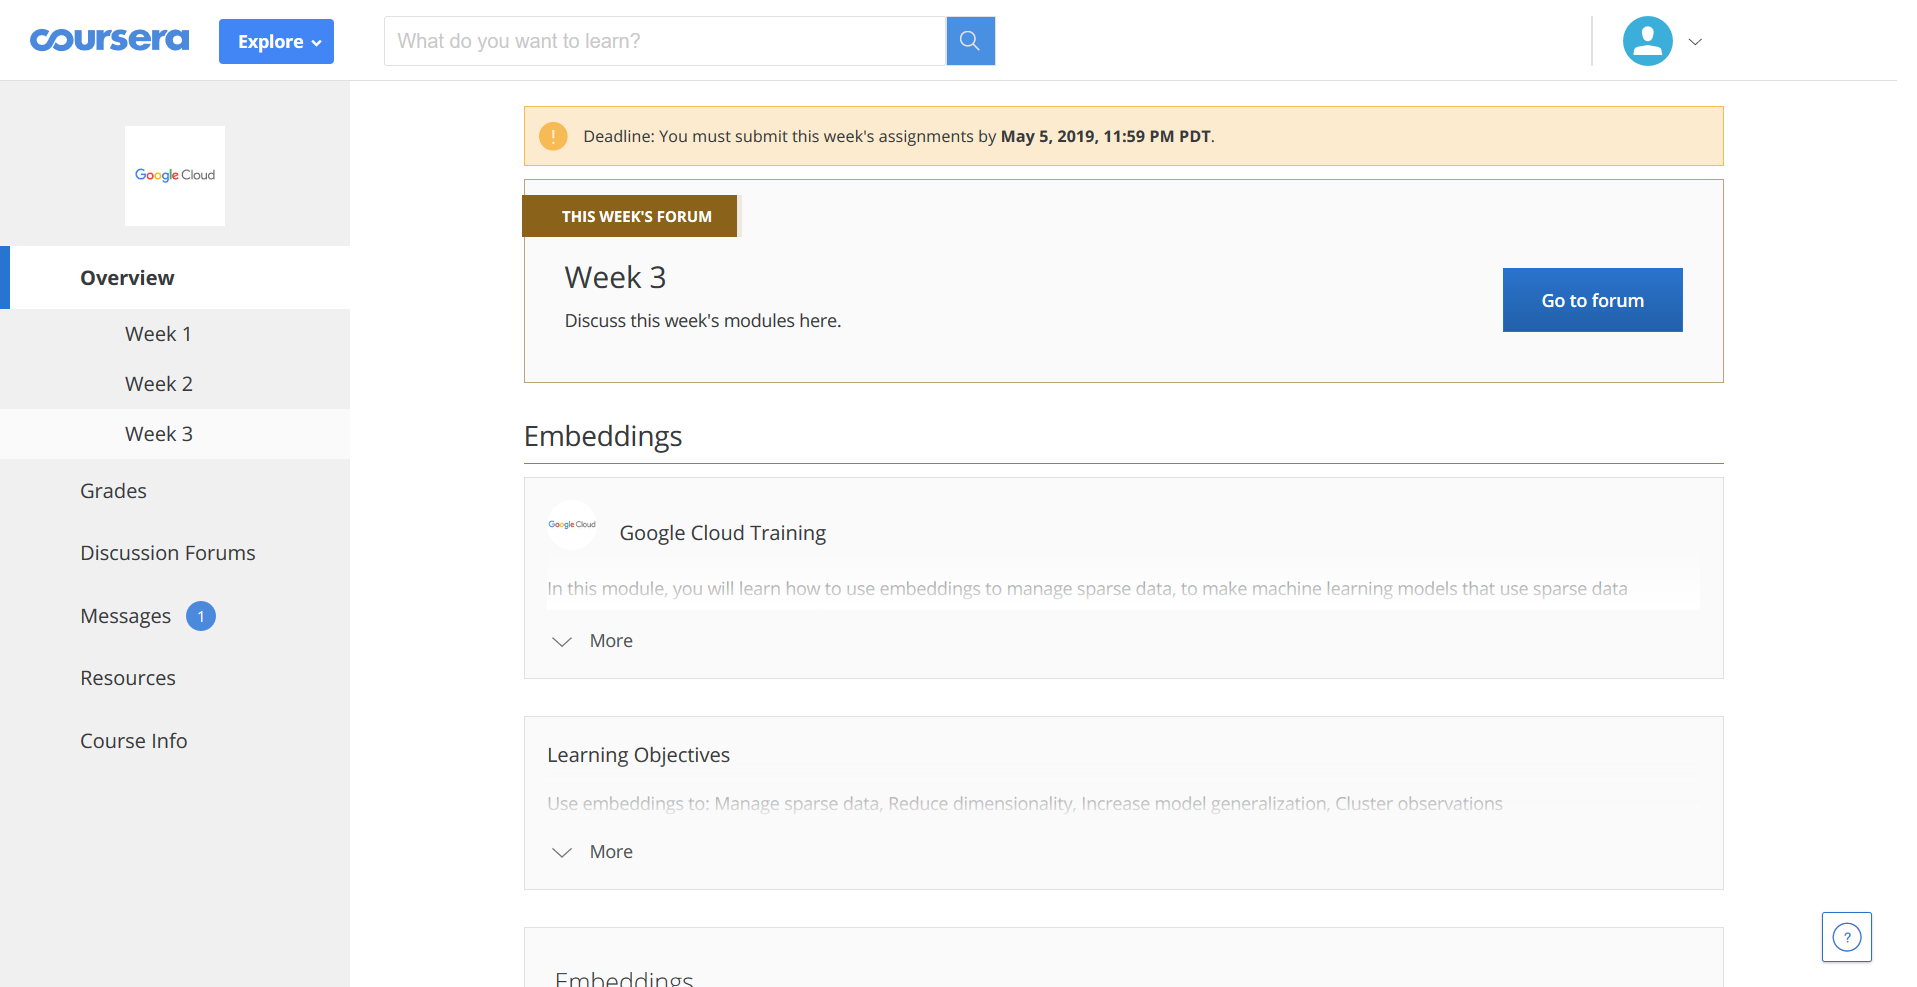

In [46]:
screenshot()

###  <b style="color:#3b5998">(3) Manually Calling Downloader Functions</b>

In [48]:
resource_idx = {}
courses_i
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    resource_idx[a] = {'title':b, 'url':c}

# USER'S HELPER FUNCTIONS

def quiz_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    quiz_downloader(a, b, c)
    
def mp4_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    mp4_downloader(a, b, c) 
    
def html_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    html_downloader(a, b, c)
    
def vtt_download_by_id(idx):
    a = idx
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    vtt_downloader(a, b, c)

### <b style="color:green">Examples of Manually Calling Functions</b>
<img src="https://images-na.ssl-images-amazon.com/images/I/41IRMu3-78L.jpg">

**`mp4_download_by_id`**

Example usage:

```
mp4_download_by_id('103')
```
is equivalent to:

**`mp4_downloader`** 

```
mp4_downloader('103',
               'Lecture Meet your lecturers',
               '/learn/competitive-data-science/lecture/k0D2h/meet-your-lecturers')
```
`103` means week `1` sequence number `03` which is a lecture

**`quiz_download_by_id`**
```
quiz_download_by_id('406')
```
is equivalent to:

**`quiz_downloader`** 

```
quiz_downloader('406',
               'Practice Quiz Practice quiz', 
               '/learn/competitive-data-science/quiz/k7xTP/practice-quiz')
```
`406` means week `4` sequence number `06` which is a quiz

In [49]:
# Example usage, edit and uncomment as you wish
#mp4_download_by_id('103')
resource_idx['307']['url']

KeyError: '307'

## <a name="close"> <b style="color:#3b5998">F. Finally Close the Browser After Download</b></a>

In [ ]:
browser.quit()
os.chdir(initial_dirname)
os.getcwd()

## <a name='goodbye'><b style="color:#3b5998">G. Good Bye</b></a>
<img src="https://media.tenor.com/images/33c7bbf779e792d8a25ba1e5b80d8c9f/tenor.gif">

## <b style="color:#3b5998">Going Back to Login?</b>
Click <a href='#login'>here</a> to restart login.

## <b style="color:#3b5998">Going Back to Table of Contents?</b>
Click <a href='#toc'>here</a> to go back to table of contents.